<a href="https://colab.research.google.com/github/ktasha45/ai-ml/blob/master/cnndae/convolutional_denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References
https://github.com/parthplc/Convolutional-Denoising-Autoencoder/blob/master/medical-image-denoising-using-autoencoders.ipynb  

## data
https://www.kaggle.com/datasets/andrewmvd/medical-mnist?resource=download

## load data & library import

In [1]:
# !cp /content/drive/MyDrive/tmp/medicalImage.zip ./
# !unzip /content/medicalImage.zip

In [2]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import math
import tqdm
import os

## define function & dataloader

In [3]:
def add_noice(image):
    batch_size, row, col, ch = image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean, sigma, (batch_size, row, col, ch))
    gauss = gauss.reshape(batch_size, row, col, ch)
    noisy = image + gauss * 0.1
    return noisy

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

class DataLoader(Sequence):
  def __init__(self, data_list, batch_size):
    self.batch_size = batch_size
    self.data_list = data_list
    
  def __getitem__(self, idx):
    scaler = StandardScaler()
    batch_x = self.data_list[idx * self.batch_size:(idx + 1) * self.batch_size]
    # y = np.array([scaler.fit_transform(imread('/content/BreastMRI/' + file_name)).reshape((64, 64, 1)) for file_name in batch_x])
    y = np.array([imread('/content/BreastMRI/' + file_name).reshape((64, 64, 1)) for file_name in batch_x]) / 255
    x = add_noice(y)
    return x, y

  def __len__(self):
    return math.ceil(len(self.data_list) / self.batch_size)

## visualize data

In [4]:
data_list = sorted(os.listdir('/content/BreastMRI'))
np.random.shuffle(data_list)
train_list = data_list[0:300]
test_list = data_list[300:600]

batch_size = 16
train_dataloader = DataLoader(train_list, batch_size)
test_dataloader = DataLoader(test_list, 1)

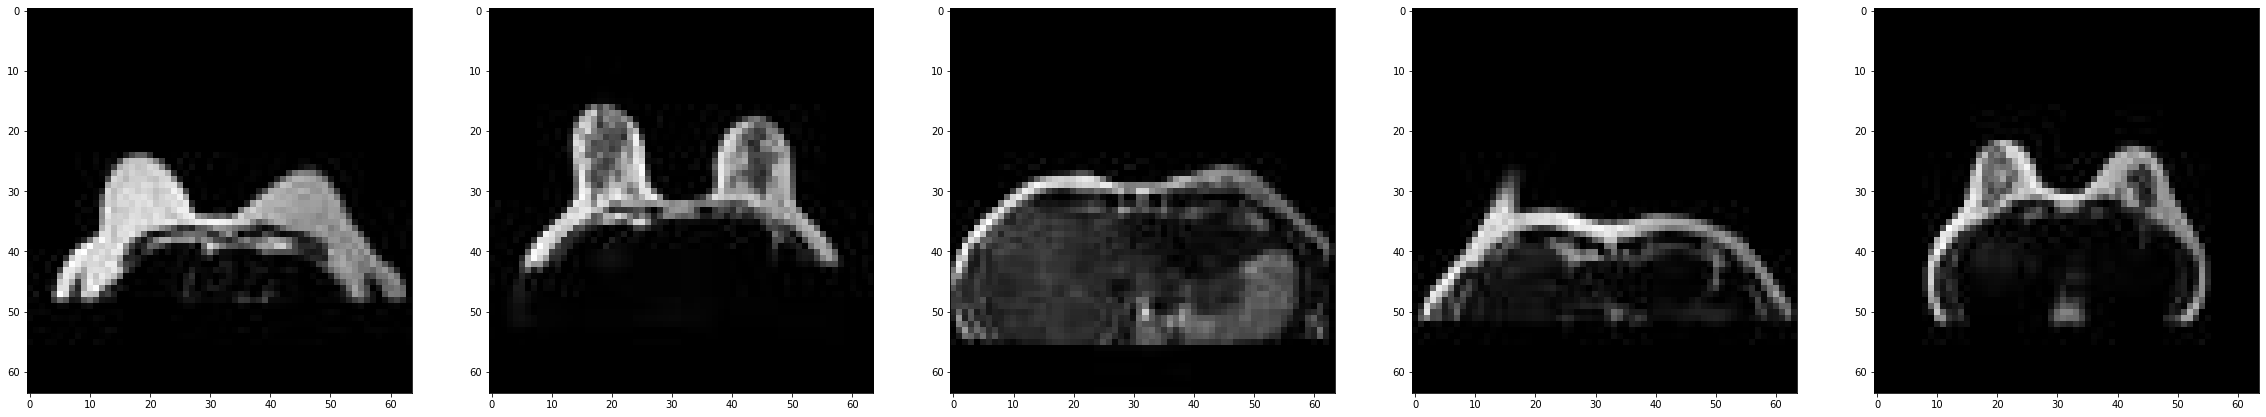

In [5]:
noised = train_dataloader.__getitem__(0)[0]
origin = train_dataloader.__getitem__(0)[1]
show_img(origin)

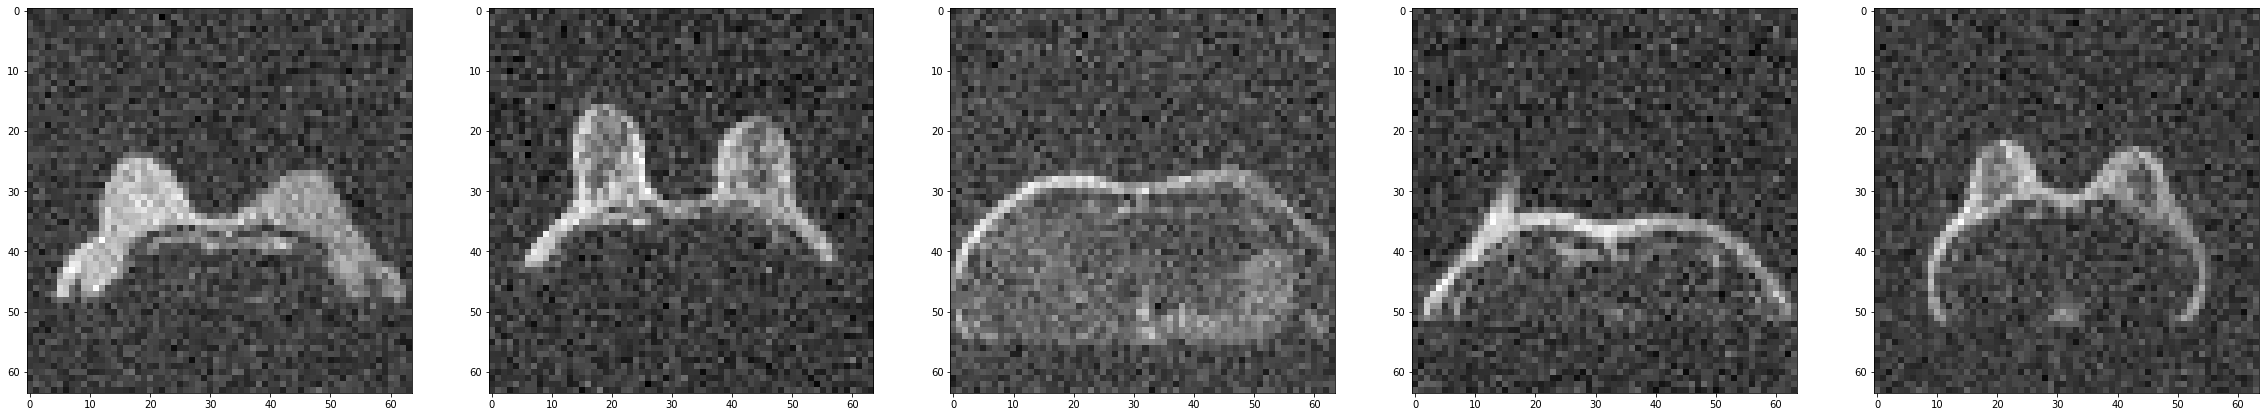

In [6]:
show_img(noised)

## create model (keras)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

model = keras.Sequential()

# encoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2,2), padding='same', name='pool1'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2'))
model.add(MaxPooling2D((2,2), padding='same', name='pool2'))

#decoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3'))
model.add(UpSampling2D((2,2), name='upsample1'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4'))
model.add(UpSampling2D((2,2), name='upsample2'))
model.add(Conv2D(1, (3,3), activation='linear', padding='same', name='Conv5'))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 64, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 32, 32, 64)        0         
                                                                 
 Conv4 (Conv2D)              (None, 32, 32, 64)        3

## train

Epoch 1/1000
19/19 [==============================] - 6s 79ms/step - loss: 0.0653 - val_loss: 0.0454
Epoch 2/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0411 - val_loss: 0.0374
Epoch 3/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0355 - val_loss: 0.0349
Epoch 4/1000
19/19 [==============================] - 2s 85ms/step - loss: 0.0329 - val_loss: 0.0317
Epoch 5/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 6/1000
19/19 [==============================] - 1s 60ms/step - loss: 0.0296 - val_loss: 0.0290
Epoch 7/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0299 - val_loss: 0.0284
Epoch 8/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0280 - val_loss: 0.0277
Epoch 9/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.0272 - val_loss: 0.0270
Epoch 10/1000
19/19 [==============================] - 1s 58ms/step - loss: 0.0267 - val_lo

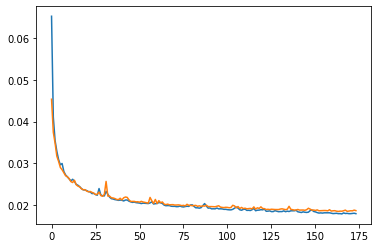

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 10,
                               verbose = 1,
                               mode = 'auto')
history = model.fit(train_dataloader,
                    epochs = 1000,
                    batch_size = 16,
                    validation_data = test_dataloader,
                    callbacks = [early_stopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## visualize result

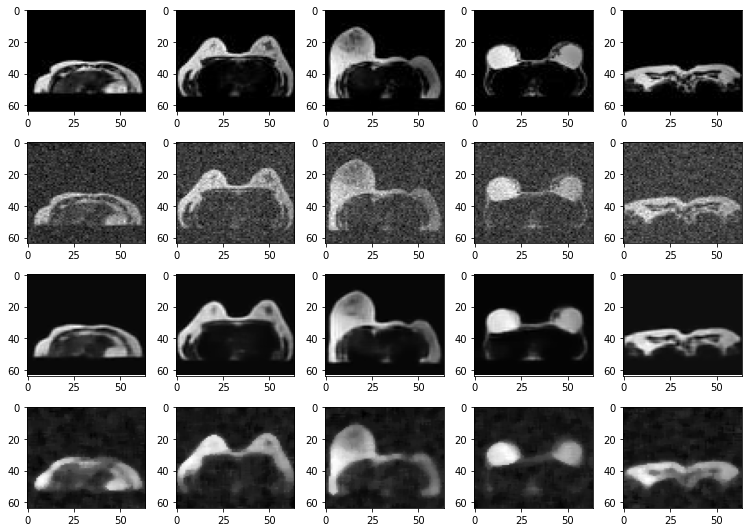

In [9]:
import cv2

def plot_predictions():    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        origin = test_dataloader.__getitem__(i)[1].astype('float32')
        noised = test_dataloader.__getitem__(i)[0].astype('float32')
        pred = model.predict(noised)

        ax[0][i].imshow(np.reshape(origin, (64, 64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(noised, (64, 64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(pred, (64, 64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(noised.reshape((64, 64)), 5), aspect='auto', cmap='gray')
    plt.tight_layout()

plot_predictions()

In [10]:
from skimage.metrics import structural_similarity as ssim

print(test_dataloader.__len__())

dae_ssim_sum = 0
median_ssim_sum = 0
noised_ssim_sum = 0

for i in test_dataloader:
  origin = i[1].reshape((64, 64)).astype('float32')
  noised = i[0]
  pred = model.predict(noised).reshape((64, 64)).astype('float32')
  median = cv2.medianBlur(noised[0].astype('float32'), 5).reshape((64, 64))
  
  (noised_ssim_score, _) = ssim(origin, noised.reshape((64, 64)).astype('float32'), full=True)
  (dae_ssim_score, _) = ssim(origin, pred, full=True)
  (median_ssim_score, _) = ssim(origin, median, full=True)

  noised_ssim_sum += noised_ssim_score
  dae_ssim_sum += dae_ssim_score
  median_ssim_sum += median_ssim_score

length = test_dataloader.__len__()
dae_ssim_avg = dae_ssim_sum / length
median_ssim_avg = median_ssim_sum / length
noised_ssim_avg = noised_ssim_sum / length

print('Noisy : {}'.format(noised_ssim_avg))
print('CNN DAE : {}'.format(dae_ssim_avg))
print('Median filter : {}'.format(median_ssim_avg))

300
Noisy : 0.48885894685556136
CNN DAE : 0.9415421359533119
Median filter : 0.7183204301191521
